
# Climate Weather AI/ML Model - Lucie


## Cluster Access
1. [Create an NCI account ](https://my.nci.org.au/mancini)using **institution email**
2. Join below NCI projects
    - [vp91:NCI Training Project](https://aus01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fmy.nci.org.au%2Fmancini%2Fproject%2Fvp91&data=05%7C02%7CZhuochen.Wu%40anu.edu.au%7Cf5a89cc20ce54084a5a408dda23d8170%7Ce37d725cab5c46249ae5f0533e486437%7C0%7C0%7C638845107242745767%7CUnknown%7CTWFpbGZsb3d8eyJFbXB0eU1hcGkiOnRydWUsIlYiOiIwLjAuMDAwMCIsIlAiOiJXaW4zMiIsIkFOIjoiTWFpbCIsIldUIjoyfQ%3D%3D%7C0%7C%7C%7C&sdata=U5QIrogOxO%2FbxR8Y7FGaB8tA1hzCGOzqP4QiFiqv5XU%3D&reserved=0)
    - [dk92: for environment modules and some examples](https://my.nci.org.au/mancini/project/dk92/join)
    - [wb00: for NCI-WeatherBench and ClimateNet datasets](https://my.nci.org.au/mancini/project/wb00/join)
    - [rt52: for ERA5 datasets](https://my.nci.org.au/mancini/project/rt52/join)
    - [ob53: for BARRA2 datasets](https://my.nci.org.au/mancini/project/ob53/join)

## Run the tested notebook
1. Go to [ARE site](are.nci.org.au), follow instructions on *[Run Jupyter Notebooks on Gadi](../Getting-Started/use-jupyterlab.qmd)* page   
2. Fill out the JupyterLab request form:  
 - **Walltime (hours)**: `1`
 - **Queue**: `gpuvolta`
 - **Compute Size**: `1gpu`
 - **Project**: `<xy01>`
 - **Storage**: `gdata/dk92+scratch/<xy01>`
3. Click ***Advanced options*** and fill in the following fields:  
 - **Module directories**: `/g/data/dk92/apps/Modules/modulefiles/`  
 - **Modules**: `NCI-ai-ml/25.07`  
 - **Jobfs size**: `10GB`    
4. Launch the session to run the tested notebook  

## Note on the tested notebook
Copy the tested notebook from any/all of the following path to your own working directory. If your working directory is different from "/scratch/<xy01>", remember to change the storage directive in the JupyterLab request form.
```bash
/g/data/dk92/notebooks/examples-aiml/lucie/data_inspection.ipynb
/g/data/dk92/notebooks/examples-aiml/lucie/replicate_training.ipynb 
/g/data/dk92/notebooks/examples-aiml/lucie/modified_training.ipynb
/g/data/dk92/notebooks/examples-aiml/lucie/inference_10y_rollout.ipynb
```
All the notebooks are using the original dataset released with the LUCIE paper inside their zenodo record [3]. 
checkpoints for models trained on Gadi is available in the directory `/g/data/dk92/notebooks/examples-aiml/lucie/checkpoints` together with the original checkpoint, `regular_8x72_fftreg_baseline.pth`, released with the LUCIE paper.

## LUCIE
LUCIE is a SFNO based atmospheric emulator that can be used for climate research. It is notable for its long-term stability in autoregressive predictions, maintaining an unbiased climatology for thousands of years. It was trained on 9.5 years of regridded ERA5 data on T30 grid, incorporating static input of orography, forcing variable of total incident solar radiation, five prognostic variables (temperature, humidity, zonal wind, meridional wind, and surface pressure), and one diagnostic variable of precipitation.  

In the paper [1], Guan et al. demonstrate LUCIE's ability to reproduce long-term climatology as well as its skill in subseasonal-to-seasonal scale predictions of atmospheric variables. Using 100 years of autoregressive inference with 100 ensemble members, they showcase the model's stability and the variability of mean climatology.  The ensemble outputs were further analysed to identify northern hemisphere annular mode(NAM), southern hemisphere annular mode (SAM) and the return period of extreme events.  

At NCI, we made the environment NCI-ai-ml compatible to run LUCIE, and prepared four notebooks introducing its dataset, training and inference workflow. In addition, we extended the model to exploit the resolution-invariant property of neural operators by removing LUCIE's positional embedding, see details in the notebook `modified_training.ipynb`. All the four notebooks are primarily based on their released code [2][3], which we adapted for training and inference on Gadi.   

Beyond the notebooks, we further tested multiple model architectural configurations, training datasets with different spatial resolutions and variable sets, and explored alternative training strategies. For example, results presented in the `Stable Rollout` section showcase a 1° model with 25 output variables, capable of generating stable rollouts at six-hour interval for up to ten years. Please note the current limitation arises from the length of our dataset, not the capability of the model.      

References:  
1.  Guan, H., Arcomano, T., Chattopadhyay, A., & Maulik, R. (2024). LUCIE: A Lightweight Uncoupled ClImate Emulator with long-term stability and physical consistency for O(1000)-member ensembles. arXiv preprint arXiv:2405.16297. https://arxiv.org/abs/2405.16297  

2.  ISCLPennState. (2024). LUCIE: Lightweight Uncoupled ClImate Emulator [Software]. GitHub. https://github.com/ISCLPennState/LUCIE  

3.  Guan, H., Arcomano, T., Chattopadhyay, A., & Maulik, R. (2025). LUCIE: A lightweight uncoupled climate emulator with long-term stability and physical consistency. Zenodo. https://doi.org/10.5281/zenodo.15164648  

# Data Inspection

In [1]:
!module list

Currently Loaded Modulefiles:
 1) openmpi/4.1.5   2) singularity   3) NCI-ai-ml/25.07   4) pbs  
>

In [2]:
import scipy.stats as stats
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
nb_dir = "/g/data/dk92/notebooks/examples-aiml/lucie"
data = np.load(f"{nb_dir}/datasets/era5_T30_regridded.npz")
data.files

['temperature',
 'humidity',
 'u_wind',
 'v_wind',
 'surface_pressure',
 'precipitation',
 'tisr',
 'orography']

## Normalization Scalars

In [4]:
# comparing mean, std to era5, t-> t1000, q -> q1000, z->z200, u-> u200, v-> v200
for var in data.files:
    mm = data[var].mean()
    ss = data[var].std()
    print(f"{var}: mean={mm}, std={ss}")

temperature: mean=277.4626770019531, std=17.816375732421875
humidity: mean=0.006629979237914085, std=0.005532822106033564
u_wind: mean=10.695755004882812, std=15.56001091003418
v_wind: mean=-0.02342492900788784, std=12.149330139160156
surface_pressure: mean=96811.390625, std=9123.89453125
precipitation: mean=0.0006106931250542402, std=0.001604488817974925
tisr: mean=1079093.125, std=1444145.25
orography: mean=367.17120361328125, std=809.2915649414062


In [6]:
data = np.load(f"{nb_dir}/datasets/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]
raw_means = data["raw_means"]
raw_stds = data["raw_stds"]
prog_means = raw_means[:5] # this is literally zero?
prog_stds = raw_stds[:5] # this is literally zero?
diag_means = data["diag_means"]
diag_stds = data["diag_stds"]
diff_means = data["diff_means"]
diff_stds = data["diff_stds"]

In [7]:
vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
list(zip(vars, raw_means, raw_stds))

[('temperature', np.float64(277.462646484375), np.float64(17.816408157348633)),
 ('humidity',
  np.float64(0.006629981566220522),
  np.float64(0.005532818380743265)),
 ('u_wind', np.float64(10.695756912231445), np.float64(15.56002426147461)),
 ('v_wind', np.float64(-0.023422522470355034), np.float64(12.14930534362793)),
 ('surface_pressure', np.float64(96811.390625), np.float64(9123.8916015625)),
 ('tisr', np.float64(1079094.75), np.float64(1444147.125)),
 ('orography', np.float64(367.17120361328125), np.float64(809.2916259765625))]

In [8]:
vars= ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure']
list(zip(vars, diff_means, diff_stds))

[('temperature',
  np.float64(9.803541615838185e-05),
  np.float64(1.4138480424880981)),
 ('humidity',
  np.float64(2.0586108817610693e-08),
  np.float64(0.0005922476993873715)),
 ('u_wind',
  np.float64(-3.1180163205135614e-05),
  np.float64(4.642238140106201)),
 ('v_wind', np.float64(-5.063314802100649e-06), np.float64(5.960874080657959)),
 ('surface_pressure',
  np.float64(0.0021911216899752617),
  np.float64(241.07797241210938))]

In [11]:
list(zip(vars,[ diff_stds[ii] / raw_stds[ii] for ii in range(5) ]))

[('temperature', np.float64(0.07935651395059314)),
 ('humidity', np.float64(0.1070426785467356)),
 ('u_wind', np.float64(0.298343888293286)),
 ('v_wind', np.float64(0.4906349714705557)),
 ('surface_pressure', np.float64(0.026422713348635562))]

In [12]:
# for log scale preciptation
diag_means,diag_stds

(array([0.05197881]), array([0.11017133]))

## Variable Fields

In [ ]:
wdir = "<replace with the working directory>"
raw_data = np.load(f"{nb_dir}/datasets/era5_T30_regridded.npz")

data = np.load(f"{nb_dir}/datasets/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]

inp_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
tar_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure','precipitation']
vars_to_plot = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography','precipitation']

raw_data["temperature"].shape, data_inp.shape, data_tar.shape

((16538, 48, 96), (16537, 7, 48, 96), (16537, 6, 48, 96))

In [14]:
def img2spectrum(img,ftr):
    npix = img.shape[-2], img.shape[-1]
    fft_img = np.fft.fftn(img)
    fft_amp = np.abs(fft_img)**2
    fft_amp = fft_amp.flatten()

    kfreq_x = np.fft.fftfreq(npix[1]) * npix[1] # wave vector
    kfreq_y = np.fft.fftfreq(npix[0]) * npix[0] # wave vector
    kfreq2D = np.meshgrid(kfreq_x, kfreq_y)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()

    #kbins = np.arange(0.5, min(*npix)//2+1, 1.)
    kbins = np.arange(0.5, ftr, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(
        knrm,
        fft_amp,
        statistic='mean',
        bins=kbins
    )

    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

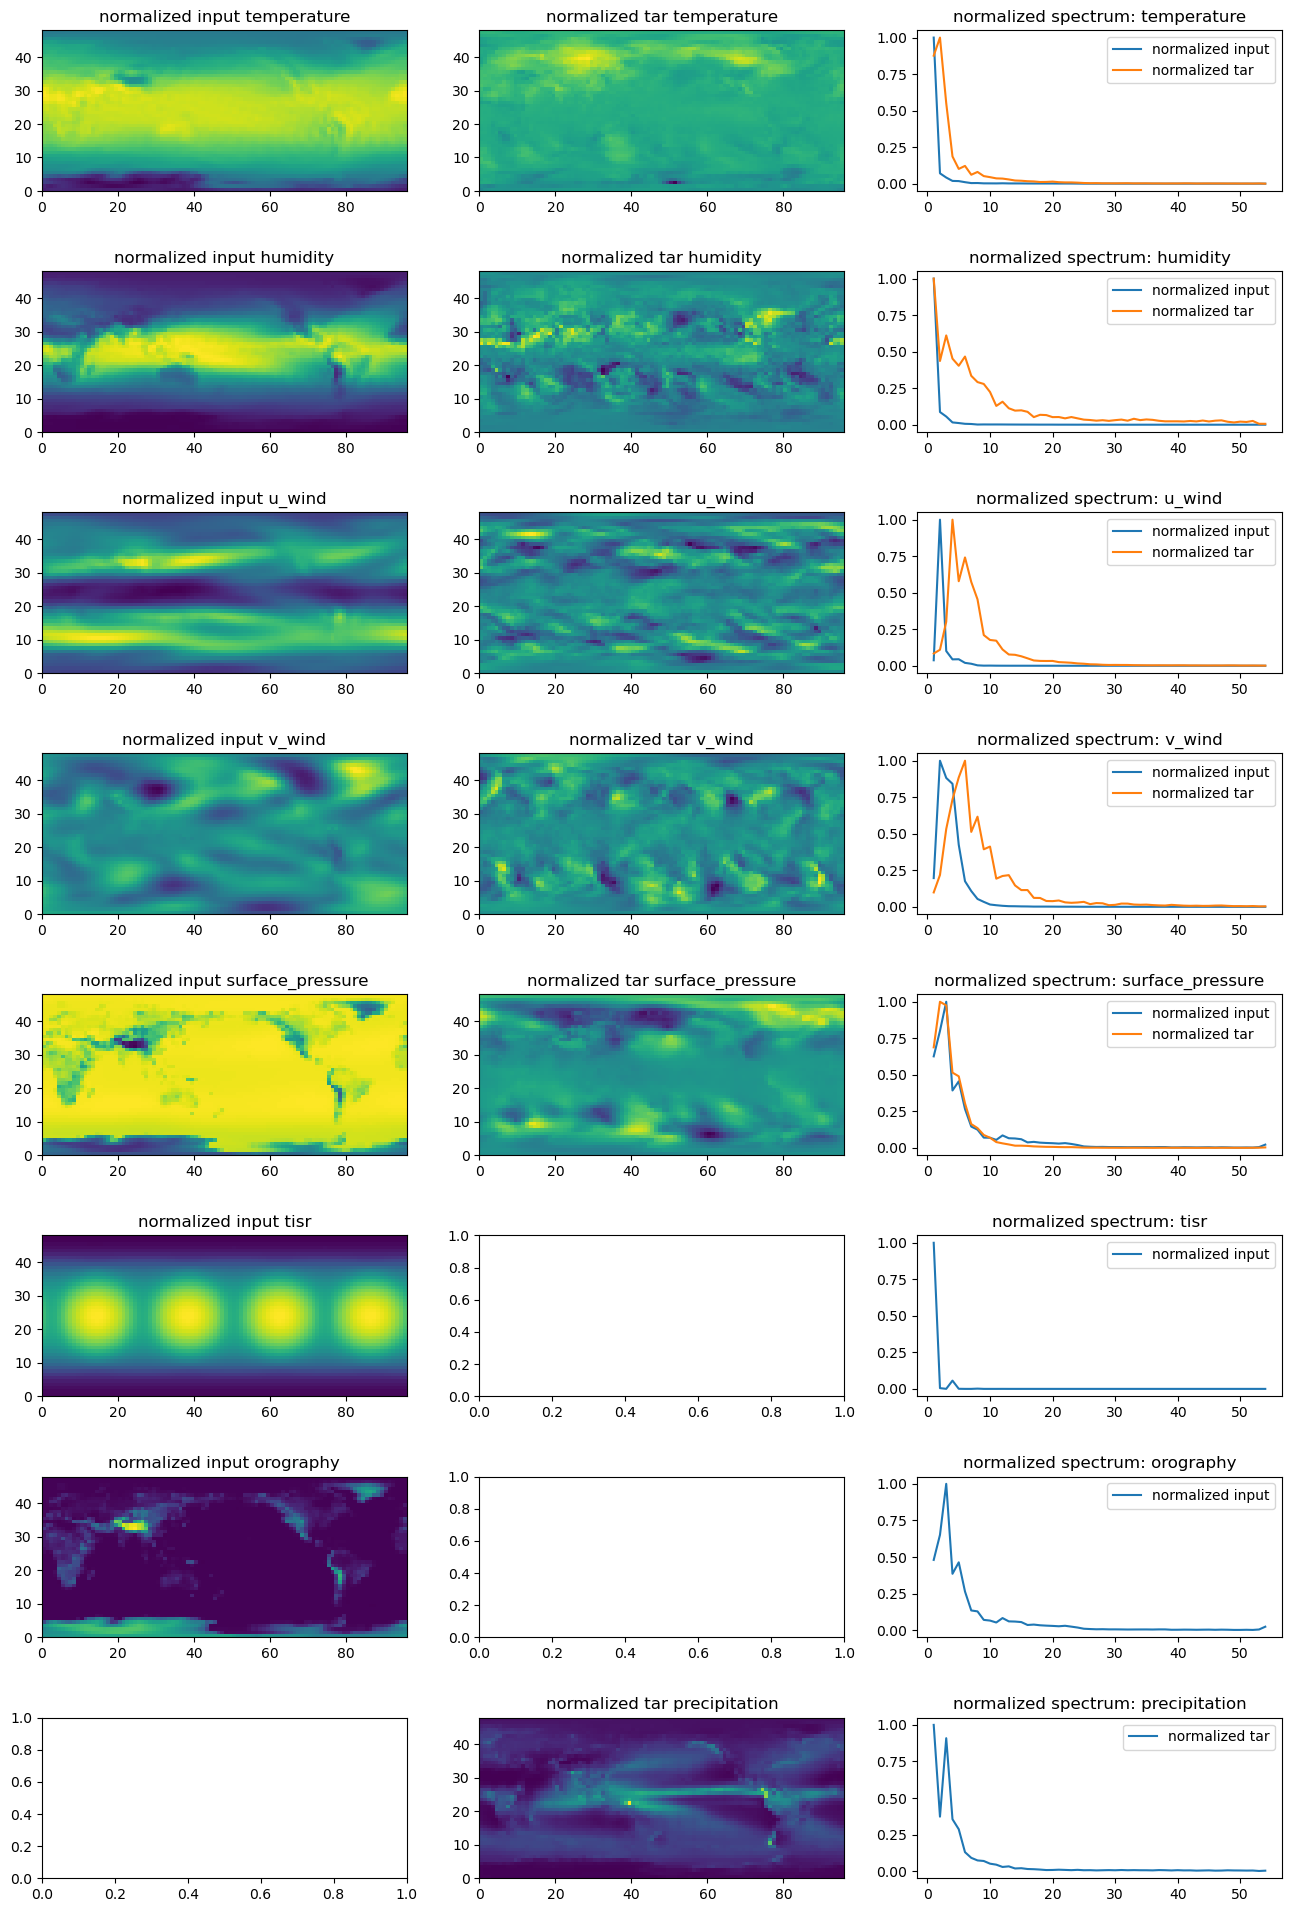

In [15]:
# plot the spatial and spectral pattern of all variable fields
fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    
    # First column: original 
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].mean(axis=(0,))
        axes[ii, 0].pcolormesh(data_norm0)
        axes[ii, 0].set_title(f"normalized input {var}")

        ftr = max(*data_norm0.shape)
        kvals0, Abins0 = img2spectrum(data_norm0,ftr)
        axes[ii, 2].plot(kvals0, Abins0/max(Abins0), label="normalized input")

    # Second column: normalized input data
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].mean(axis=(0,))
        axes[ii, 1].pcolormesh(data_norm1)
        axes[ii, 1].set_title(f"normalized tar {var}")

        ftr = max(*data_norm1.shape)
        kvals1, Abins1 = img2spectrum(data_norm1,ftr)
        axes[ii, 2].plot(kvals1, Abins1/max(Abins1), label="normalized tar")
        
    # third column: normalized output data
    axes[ii, 2].legend()
    axes[ii, 2].set_title(f"normalized spectrum: {var}")
    
plt.subplots_adjust(hspace=0.5)

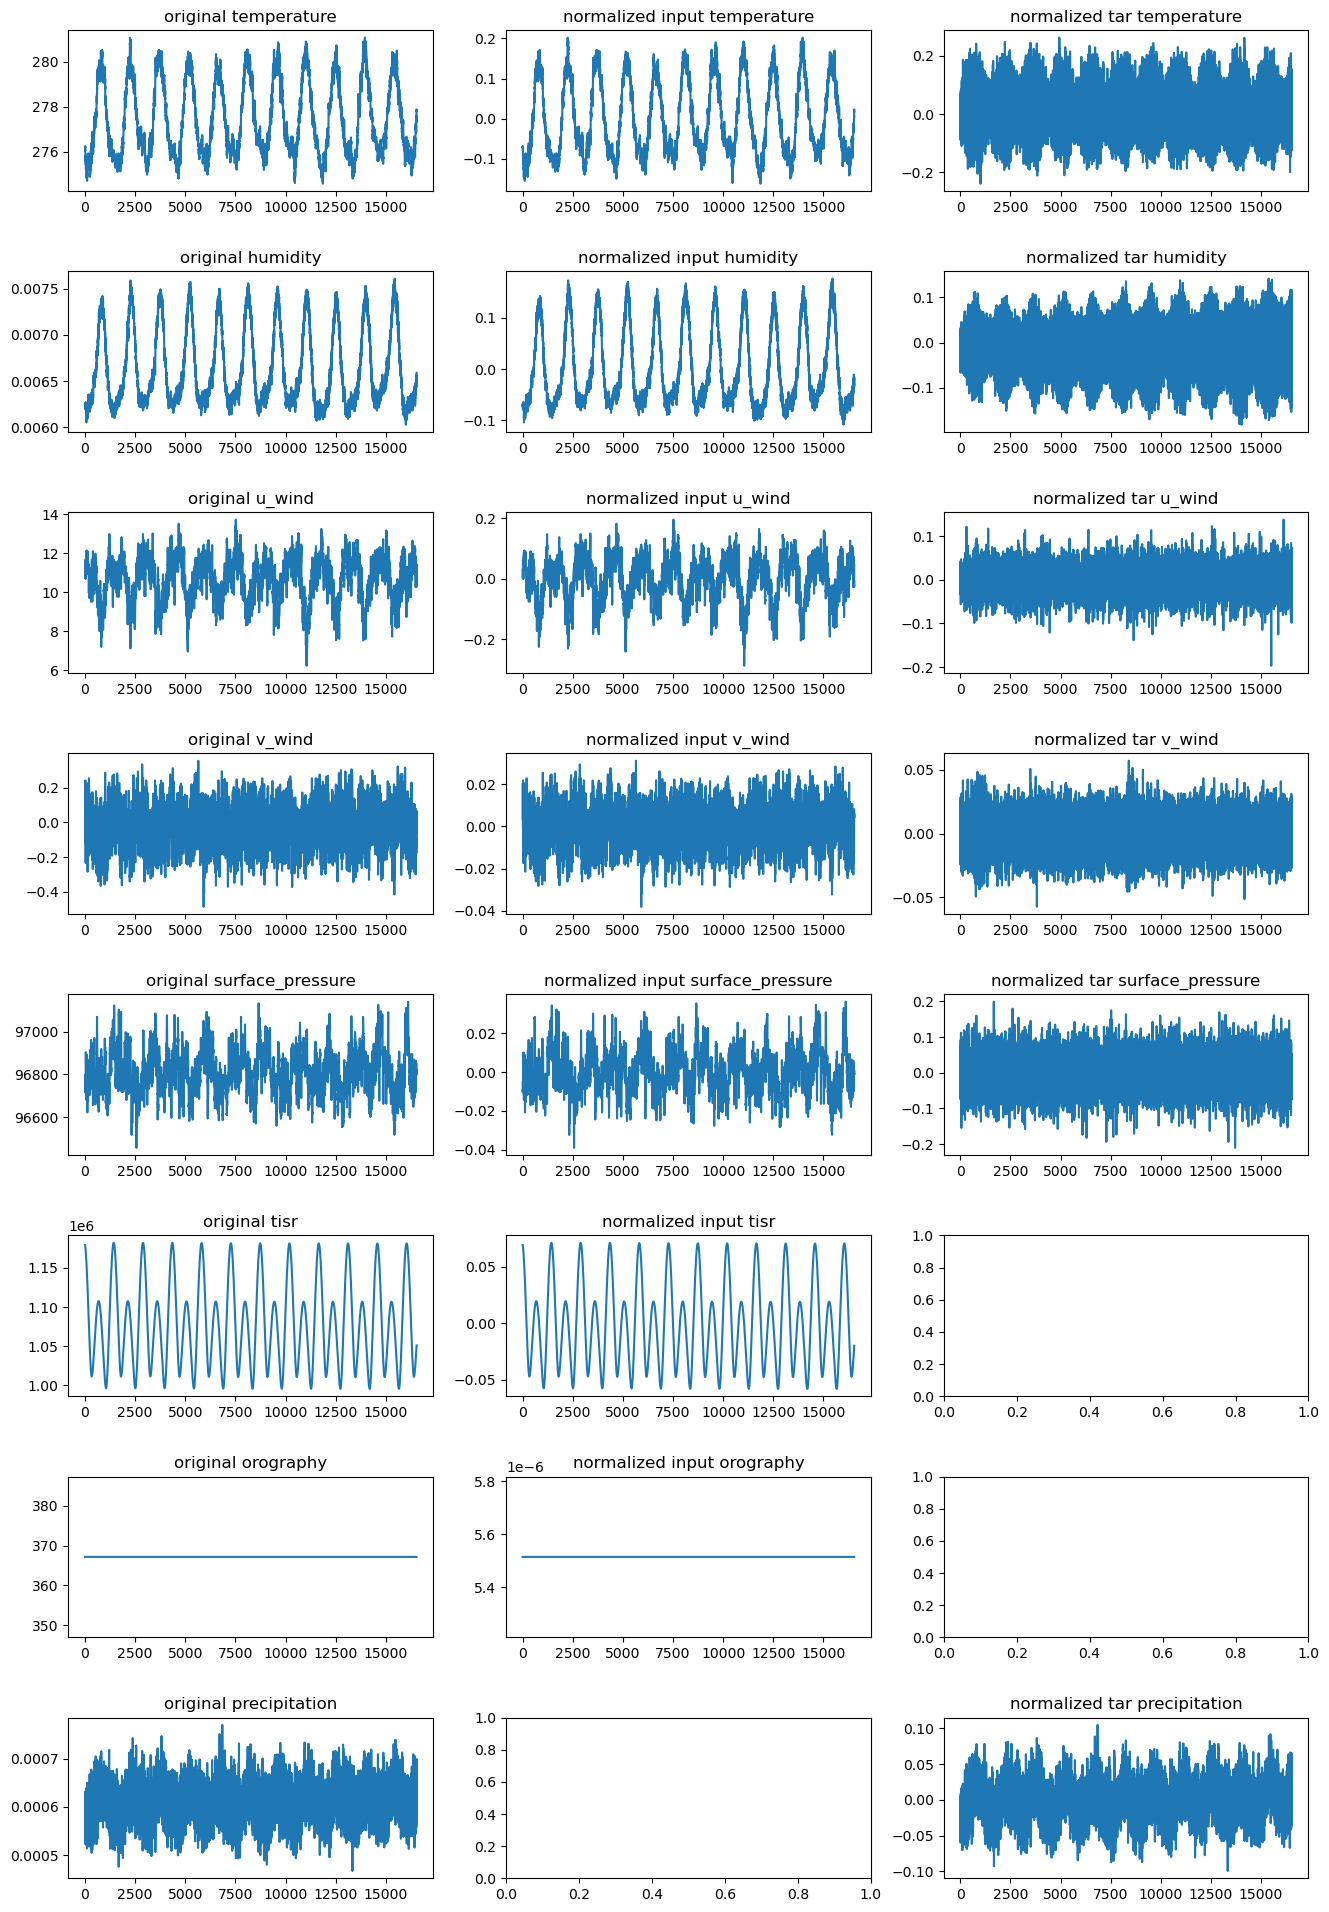

In [17]:
# plot the global mean over time of each variable

fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    
    # First column: normalized input data
    data = raw_data[var]
    axes[ii, 0].plot(data.mean(axis=(-2,-1)))
    axes[ii, 0].set_title(f"original {var}")

    # Second column: normalized output data
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].mean(axis=(-2,-1))
        axes[ii, 1].plot(data_norm0)
        axes[ii, 1].set_title(f"normalized input {var}")

    # third column: normalized input vs output data spectrum
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].mean(axis=(-2,-1))
        axes[ii, 2].plot(data_norm1)
        axes[ii, 2].set_title(f"normalized tar {var}")
    
plt.subplots_adjust(hspace=0.5)

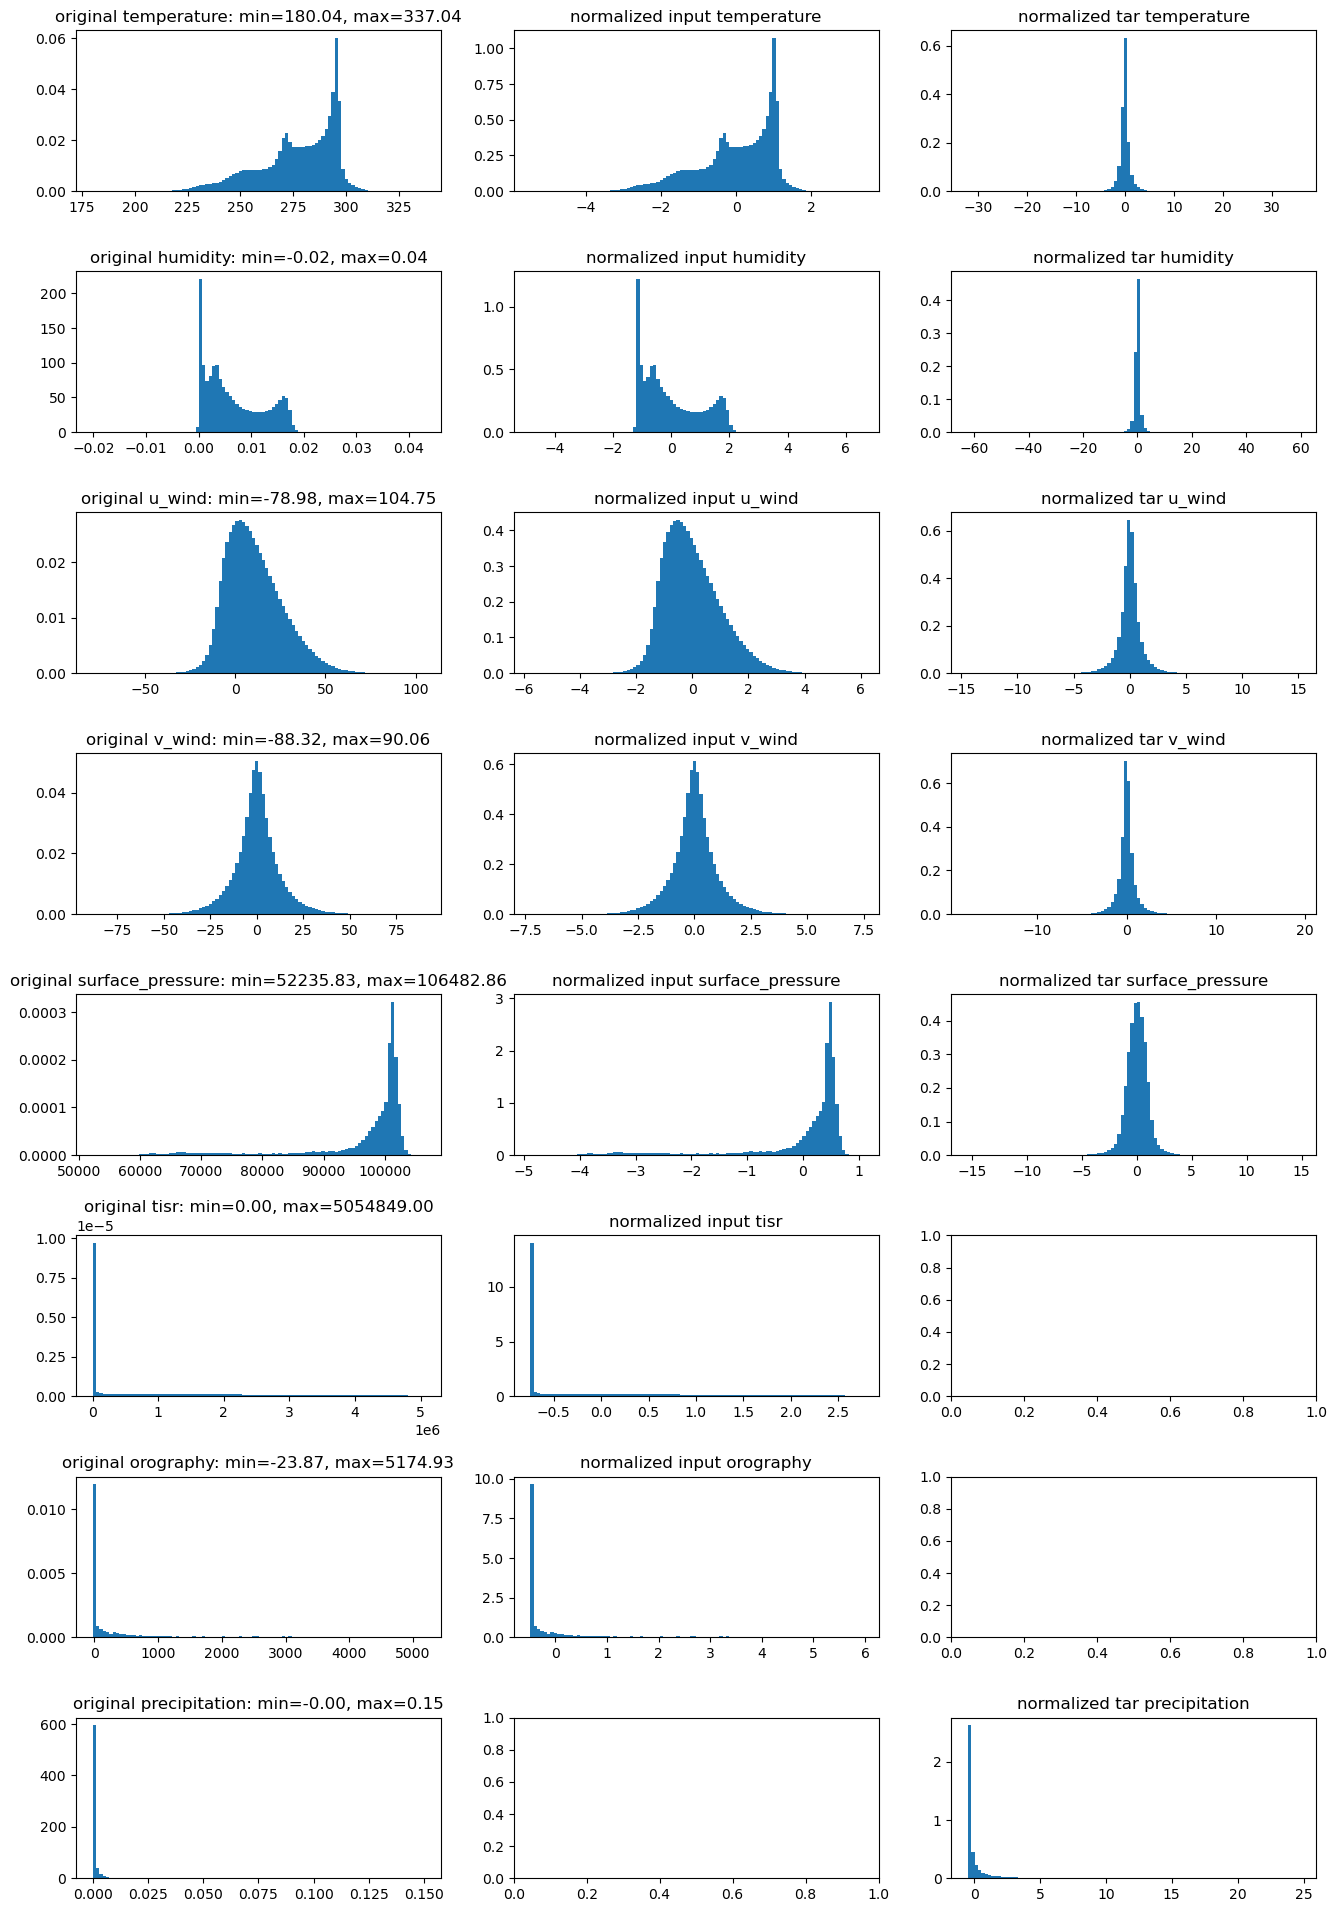

In [ ]:
# plot the distribution of all variable fileds

wdir = "<replace with the working directory>"
raw_data = np.load(f"{wdir}/era5_T30_regridded.npz")

data = np.load(f"{wdir}/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]

inp_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
tar_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure','precipitation']
vars_to_plot = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography','precipitation']

fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    data = raw_data[var]
    data = data[~np.isnan(data)]
    # Compute min, max, 5th and 95th percentiles
    vmin = data.min()
    vmax = data.max()

    # First column: original 
    axes[ii, 0].hist(data, bins=100,density=True)
    axes[ii, 0].set_title(f"original {var}: min={vmin:.2f}, max={vmax:.2f}")

    # Second column: normalized input data
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].flatten()
        axes[ii, 1].hist(data_norm0, bins=100, density=True)
        axes[ii, 1].set_title(f"normalized input {var}")

    # third column: normalized output data
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].flatten()
        axes[ii, 2].hist(data_norm1, bins=100, density=True)
        axes[ii, 2].set_title(f"normalized tar {var}")
    
plt.subplots_adjust(hspace=0.5)

# Replicate Training


In [ ]:
!module list

Currently Loaded Modulefiles:
 1) openmpi/4.1.5   2) singularity   3) NCI-ai-ml/25.07   4) pbs  
>

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import sys,os,time
nb_dir="/g/data/dk92/notebooks/examples-aiml/lucie"
sys.path.append(f"{nb_dir}/models")
from torch_harmonics_local import *
from LUCIE_inference import inference

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [ ]:
# define util functions, overide the one defined in LUCIE_train.py
def integrate_grid(ugrid):
    dlon = 2 * torch.pi / nlon
    out = torch.sum(ugrid * quad_weights * dlon, dim=(-2, -1))
    return out

def l2loss_sphere(prd, tar, relative=False, squared=True):
    loss = integrate_grid((prd - tar)**2).sum(dim=-1)
    if relative:
        loss = loss / integrate_grid(tar**2).sum(dim=-1)

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

def train_model(model, tdl, optimizer, scheduler=None, nepochs=20, loss_fn='l2'):
    infer_bias = 1e+80
    ibs = torch.zeros(1,nepochs)
    best_bias = 1e+80
    recall_count = 0
    acc_losses = []
    epoch_times = []
    #ckpt_dir=f"{os.environ['PBS_O_WORKDIR']}/checkpoints/{os.environ['PBS_JOBID']}"
    ckpt_dir=os.getcwd()
    for epoch in range(nepochs):
        tstamp=time.strftime("%H:%M:%S",time.localtime())
        print(f'--------------------------------------------------------------------------------')
        print(f"{tstamp}: epoch {epoch} start")
        epoch_start = time.time()

        if epoch < 149:
            if scheduler is not None:
                scheduler.step()
                print(f'using scheduler: current learning rate = {scheduler.get_last_lr()}')
        else:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6

            print(f"current learning rate = {optimizer.param_groups[0]['lr']}")

        optimizer.zero_grad()

        acc_loss = 0
        model.train()
        #batch_num = 0
        for inp, tar in tdl:
            #batch_num += 1
            #loss = 0

            inp = inp.to(device)
            tar = tar.to(device)
            prd = model(inp)

            loss_delta = l2loss_sphere(prd[:,:5,:,:], tar[:,:5,:,:], relative=True)
            loss_tp = torch.mean((prd[:,5:,:,:]-tar[:,5:,:,:])**2)
            loss = loss_delta + loss_tp / tar.shape[1]

            if epoch > 150:
                #print(f"add spectral loss")
                lat_index = np.r_[7:15, 32:40]
                out_fft = torch.mean(torch.abs(torch.fft.rfft(prd[:,:,lat_index,:],dim=3)),dim=2)
                target_fft = torch.mean(torch.abs(torch.fft.rfft(tar[:,:,lat_index,:],dim=3)),dim=2)
                loss_reg = 0.05 * torch.mean(torch.abs(out_fft - target_fft))
                loss = loss + loss_reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc_loss += loss.item()* inp.size(0)

        acc_losses.append(acc_loss / len(tdl.dataset))

        epoch_times.append(time.time() - epoch_start)
        tstamp=time.strftime("%H:%M:%S",time.localtime())
        print(f'{tstamp}: Epoch {epoch} summary:')
        print(f'time taken: {epoch_times[-1]}')
        print(f'nsamples / sec: {len(tdl.dataset)/epoch_times[-1]}')
        print(f'average training loss: {acc_losses[-1]}')

        if epoch >= 60:
            rollout_steps = 2920
            rollout = torch.tensor(inference(model, rollout_steps, data_inp[0:1].to(device), data_inp[:1460,-2:].to(device), 1, prog_means, prog_stds, diag_means, diag_stds, diff_stds)).to(device)
            rollout_clim = torch.mean(rollout[1460:],dim=0)
            clim_bias = torch.mean(torch.abs(rollout_clim - true_clim))
            ibs[0,epoch] = clim_bias
            if len(ibs>0)<=20:
                infer_bias = torch.mean(torch.tensor(ibs[0,60:epoch+1]))
            else:
                infer_bias = torch.mean(ibs[0,epoch-20:epoch+1])

            print(f'clim_bias: {clim_bias}')
            print(f'infer_bias: {infer_bias}')
            if clim_bias <= best_bias:
                print(f"new best clim_bias, save checkpoint")
                best_bias = clim_bias
                #torch.save({"epoch":epoch,"model_state_dict":model.state_dict(),"optim_state_dict":optimizer.state_dict(),"sch_state_dict":scheduler.state_dict()},f"{ckpt_dir}/lucie_{epoch}.pt")
                torch.save(model.state_dict(), f"{ckpt_dir}/regular_training_checkpoint.pth")

            if epoch % 10 == 0:
                if ~torch.isnan(clim_bias):
                    if clim_bias <= infer_bias:
                        #print(f"clim_bias <= {infer_bias}, save checkpoint")
                        #infer_bias = clim_bias
                        #torch.save(model.state_dict(), f"{ckpt_dir}/regular_training_checkpoint.pth")
                        recall_count = 0
                    else:
                        print(f"clim_bias > {infer_bias}, recall from latest checkpoint")
                        state_pth = torch.load(f"{ckpt_dir}/regular_training_checkpoint.pth")
                        model.load_state_dict(state_pth)
                        recall_count += 1
                        if recall_count > 3:
                            break


In [ ]:
# load data
data = load_data(f"{nb_dir}/datasets/era5_T30_regridded.npz")[...,:6]
true_clim = torch.tensor(np.mean(data, axis=0)).to(device).permute(2,0,1)

data = np.load(f"{nb_dir}/datasets/era5_T30_preprocessed.npz")     # standardized data with mean and stds generated from dataset_generator.py
data_inp = torch.tensor(data["data_inp"],dtype=torch.float32)     # input data 
data_tar = torch.tensor(data["data_tar"],dtype=torch.float32)
raw_means = torch.tensor(data["raw_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
raw_stds = torch.tensor(data["raw_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
prog_means = raw_means[:,:5]
prog_stds = raw_stds[:,:5]
diag_means = torch.tensor(data["diag_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diag_stds = torch.tensor(data["diag_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_means = torch.tensor(data["diff_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_stds = torch.tensor(data["diff_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)

ntrain = 16000
train_set = TensorDataset(data_inp[:ntrain],data_tar[:ntrain])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

In [ ]:
# set the model
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)
model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),
                    num_layers=8, in_chans=7, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed="latlon", use_mlp=True,
                                            normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,
                                            mlp_ratio = 2.).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-5)
print(sum(p.numel() for p in model.parameters()))

4122864


In [ ]:
# it takes roughly 75 sec per epoch to train the original LUCIE model on a single V100
# checkpoint saved at epoch 340 is available in `/g/data/dk92/notebooks/examples-aiml/lucie/checkpoints/`
nepochs=3
train_model(model, train_loader, optimizer, scheduler=scheduler, nepochs=nepochs)

--------------------------------------------------------------------------------
18:39:35: epoch 0 start
using scheduler: current learning rate = [9.998026259498021e-05]


/opt/conda/envs/mlenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:990: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


18:40:49: Epoch 0 summary:
time taken: 73.2493634223938
nsamples / sec: 218.43193240787235
average training loss: 0.568795047662941
--------------------------------------------------------------------------------
18:40:49: epoch 1 start
using scheduler: current learning rate = [9.993093369094605e-05]
18:42:02: Epoch 1 summary:
time taken: 73.02629399299622
nsamples / sec: 219.0991644945658
average training loss: 0.44222918830883634
--------------------------------------------------------------------------------
18:42:02: epoch 2 start
using scheduler: current learning rate = [9.986190524833163e-05]
18:43:15: Epoch 2 summary:
time taken: 72.95869874954224
nsamples / sec: 219.30215689462784
average training loss: 0.4068589104065609


## Suggested Exercises
1. plot the learning curve of the training: y-axis: average training loss, x-axis: epoch.
2. modify `rollout_clim` and `true_clim` to be the latitude-weighted global mean and re-run the training
3. try expand the region where the added spectral loss covers and re-run the training.

# Modified Training



In [ ]:
!module list

Currently Loaded Modulefiles:
 1) openmpi/4.1.5   2) singularity   3) NCI-ai-ml/25.07   4) pbs  
>

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import sys,os,time
nb_dir="/g/data/dk92/notebooks/examples-aiml/lucie"
sys.path.append(f"{nb_dir}/models")
from torch_harmonics_local_v2 import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [ ]:
# normalization function used for static channels. 
def _minmax(img):
        return torch.as_tensor((img-img.min())/(img.max()-img.min()))

def generate_t30_grid():
    nlat = 48  # Number of latitudes
    nlon = 96  # Number of longitudes

    # Gaussian latitudes and weights
    latitudes, weights = np.polynomial.legendre.leggauss(nlat)
    latitudes = np.arcsin(latitudes) * (180.0 / np.pi)  # Convert to degrees

    # Longitudes
    longitudes = np.linspace(0, 360, nlon, endpoint=False)

    return latitudes, longitudes

In [ ]:
# modified inference function adapted to lat,lon inputs
def inference(model, steps, initial_frame, forcing, initial_forcing_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds):
    inf_data = []
    inp_const =const_chans.to(device,dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        inp_val = initial_frame
        for i in range(steps):
            forcing_idx = (initial_forcing_idx + i) % 1460      # tisr is repeating and orography is 
            previous = inp_val[:,:5,:,:]
            inpc_val = torch.cat([inp_const, inp_val],dim=1)
            pred = model(inpc_val)
            pred[:,:5,:,:] = pred[:,:5,:,:] * diff_stds         # denormalize the predicted tendency
            
            # demornalzie the previous time step and add to the tendecy to reconstruct the current field
            pred[:,:5,:,:] += previous[:,:5,:,:] * prog_stds + prog_means
            
            tp_frame = pred[:,5:,:,:] * diag_stds + diag_means
            raw = torch.cat((pred[:,:5,:,:],tp_frame), 1)
            
            inp_val = (raw[:,:5,:,:] - prog_means) / prog_stds      # normalize the current time step for autoregressive prediction
            inp_val = torch.cat((inp_val, forcing[forcing_idx,:,:,:].reshape(1,2,48,96)), dim=1)
            raw = raw.cpu().clone().detach().numpy()
            inf_data.append(raw[0])

    inf_data = np.array(inf_data)
    inf_data[:,5,:,:] = (np.exp(inf_data[:,5,:,:]) - 1) * 1e-2      # denormalzie precipitation that was normalized in log space
    return inf_data

In [ ]:
# define util functions, overide the one defined in LUCIE_train.py
def integrate_grid(ugrid):
    dlon = 2 * torch.pi / nlon
    out = torch.sum(ugrid * quad_weights * dlon, dim=(-2, -1))
    return out

def l2loss_sphere(prd, tar, relative=False, squared=True):
    loss = integrate_grid((prd - tar)**2).sum(dim=-1)
    if relative:
        loss = loss / integrate_grid(tar**2).sum(dim=-1)

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

def train_model(model, tdl, optimizer, scheduler=None, nepochs=20, loss_fn='l2'):
    infer_bias = 1e+80
    ibs = torch.zeros(1,nepochs)
    best_bias = 1e+80
    recall_count = 0
    acc_losses = []
    epoch_times = []
    #ckpt_dir=f"{os.environ['PBS_O_WORKDIR']}/checkpoints/{os.environ['PBS_JOBID']}"
    for epoch in range(nepochs):
        tstamp=time.strftime("%H:%M:%S",time.localtime())
        print(f'--------------------------------------------------------------------------------')
        print(f"{tstamp}: epoch {epoch} start")
        epoch_start = time.time()
        
        if epoch < 149:
            if scheduler is not None:
                scheduler.step()
                print(f'using scheduler: current learning rate = {scheduler.get_last_lr()}')
        else:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6
                
            print(f"current learning rate = {optimizer.param_groups[0]['lr']}")
        
        optimizer.zero_grad()

        acc_loss = 0
        model.train()
        #batch_num = 0
        for inp, tar in tdl:
            #batch_num += 1
            #loss = 0

            #inp = inp.to(device)
            # adding lat, lon as the first two channels
            inpc = torch.cat([const_chans_t, inp],dim=1).to(device,dtype=torch.float32)
            tar = tar.to(device)
            prd = model(inpc)

            # prd and tar shape are not affected, keep this section
            loss_delta = l2loss_sphere(prd[:,:5,:,:], tar[:,:5,:,:], relative=True)
            loss_tp = torch.mean((prd[:,5:,:,:]-tar[:,5:,:,:])**2)
            loss = loss_delta + loss_tp / tar.shape[1]

            if epoch > 150:
                #print(f"add spectral loss")
                lat_index = np.r_[7:15, 32:40]
                out_fft = torch.mean(torch.abs(torch.fft.rfft(prd[:,:,lat_index,:],dim=3)),dim=2)
                target_fft = torch.mean(torch.abs(torch.fft.rfft(tar[:,:,lat_index,:],dim=3)),dim=2)
                loss_reg = 0.05 * torch.mean(torch.abs(out_fft - target_fft))
                loss = loss + loss_reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc_loss += loss.item()* inp.size(0)
            
        acc_losses.append(acc_loss / len(tdl.dataset))

        epoch_times.append(time.time() - epoch_start)
        tstamp=time.strftime("%H:%M:%S",time.localtime())
        print(f'{tstamp}: Epoch {epoch} summary:')
        print(f'time taken: {epoch_times[-1]}')
        print(f'nsamples / sec: {len(tdl.dataset)/epoch_times[-1]}')
        print(f'average training loss: {acc_losses[-1]}')

        if epoch >= 60:
            rollout_steps = 2920
            rollout = torch.tensor(inference(model, rollout_steps, data_inp[0:1].to(device), data_inp[:1460,-2:].to(device), 1, prog_means, prog_stds, diag_means, diag_stds, diff_stds)).to(device)
            rollout_clim = torch.mean(rollout[1460:],dim=0)
            clim_bias = torch.mean(torch.abs(rollout_clim - true_clim))
            ibs[0,epoch] = clim_bias
            if len(ibs>0)<=20:
                infer_bias = torch.mean(torch.tensor(ibs[0,60:epoch+1]))
            else:
                infer_bias = torch.mean(ibs[0,epoch-20:epoch+1])

            print(f'clim_bias: {clim_bias}')
            print(f'infer_bias: {infer_bias}')
            if clim_bias <= best_bias:
                print(f"new best clim_bias, save checkpoint")
                best_bias = clim_bias
                #torch.save({"epoch":epoch,"model_state_dict":model.state_dict(),"optim_state_dict":optimizer.state_dict(),"sch_state_dict":scheduler.state_dict()},f"{ckpt_dir}/lucie_{epoch}.pt")
                torch.save(model.state_dict(), f"{ckpt_dir}/regular_training_checkpoint.pth")
         
            if epoch % 10 == 0:
                if ~torch.isnan(clim_bias): 
                    if clim_bias <= infer_bias:
                        #print(f"clim_bias <= {infer_bias}, save checkpoint")
                        #infer_bias = clim_bias
                        #torch.save(model.state_dict(), f"{ckpt_dir}/regular_training_checkpoint.pth")
                        recall_count = 0
                    else:
                        print(f"clim_bias > {infer_bias}, recall from latest checkpoint")
                        state_pth = torch.load(f"{ckpt_dir}/regular_training_checkpoint.pth")
                        model.load_state_dict(state_pth)
                        recall_count += 1
                        if recall_count > 3:
                            break


In [ ]:
# load data
data = load_data(f"{nb_dir}/datasets/era5_T30_regridded.npz")[...,:6]
true_clim = torch.tensor(np.mean(data, axis=0)).to(device).permute(2,0,1)

data = np.load(f"{nb_dir}/datasets/era5_T30_preprocessed.npz")     # standardized data with mean and stds generated from dataset_generator.py
data_inp = torch.tensor(data["data_inp"],dtype=torch.float32)     # input data 
data_tar = torch.tensor(data["data_tar"],dtype=torch.float32)
raw_means = torch.tensor(data["raw_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
raw_stds = torch.tensor(data["raw_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
prog_means = raw_means[:,:5]
prog_stds = raw_stds[:,:5]
diag_means = torch.tensor(data["diag_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diag_stds = torch.tensor(data["diag_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_means = torch.tensor(data["diff_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_stds = torch.tensor(data["diff_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)

ntrain = 16000
train_set = TensorDataset(data_inp[:ntrain],data_tar[:ntrain])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)

# generate the const channels
lats, lons = generate_t30_grid()
lon2d, lat2d = np.meshgrid(lons, lats)
const_chans = _minmax(np.stack([_minmax(lat2d), _minmax(lon2d)])).unsqueeze(0)
const_chans_t = const_chans.expand(16, 2, 48, 96)

In [ ]:
# set the model
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)
model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),num_layers=8, in_chans=9, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed=False, use_mlp=True,normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,mlp_ratio = 2.).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-5)
print(sum(p.numel() for p in model.parameters()))

3791376


In [ ]:
# it takes roughly 75 sec per epoch to train the modified LUCIE model on a single V100
# checkpoints saved at epoch 193 and 219 are available in `/g/data/dk92/notebooks/examples-aiml/lucie/checkpoints/`
nepochs=3
train_model(model, train_loader, optimizer, scheduler=scheduler, nepochs=nepochs)

--------------------------------------------------------------------------------
17:55:28: epoch 0 start
using scheduler: current learning rate = [9.999013075636805e-05]


/opt/conda/envs/mlenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


17:56:44: Epoch 0 summary:
time taken: 75.56519341468811
nsamples / sec: 211.73769664288284
average training loss: 0.5649356337823864
--------------------------------------------------------------------------------
17:56:44: epoch 1 start
using scheduler: current learning rate = [9.996052735444863e-05]
17:57:58: Epoch 1 summary:
time taken: 74.5183458328247
nsamples / sec: 214.71222718623653
average training loss: 0.4445175377408696
--------------------------------------------------------------------------------
17:57:58: epoch 2 start
using scheduler: current learning rate = [9.991120277927221e-05]
17:59:13: Epoch 2 summary:
time taken: 74.4180178642273
nsamples / sec: 215.00169527749802
average training loss: 0.41059033054741506


## Suggested Exercises
1. identify the difference between the above `model` and the `model` used in `/g/data/dk92/notebooks/examples-aiml/lucie/replicate_training.ipynb`.
2. compare learning curve of this training and the one defined in `/g/data/dk92/notebooks/examples-aiml/lucie/replicate_training.ipynb`.
3. compare rollouts generated from this model and the one trained in `/g/data/dk92/notebooks/examples-aiml/lucie/replicate_training.ipynb`.
4. modify the model further to have higher embedding dimension in the feature space.

# Inference


In [ ]:
!module list

Currently Loaded Modulefiles:
 1) openmpi/4.1.5   2) singularity   3) NCI-ai-ml/25.07   4) pbs  
>

In [ ]:
from math import ceil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch

import sys,os,time
nb_dir="/g/data/dk92/notebooks/examples-aiml/lucie"
sys.path.append(f"{nb_dir}/models")
from torch_harmonics_local import *
from LUCIE_inference import inference

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [ ]:
# load the ground truth for clim_bias from the original work
data = load_data(f"{nb_dir}/datasets/era5_T30_regridded.npz")[...,:6]
true_clim = torch.tensor(np.mean(data, axis=0)).to(device).permute(2,0,1)

In [ ]:
# load the normalization scalars from the original work
data = np.load(f"{nb_dir}/datasets/era5_T30_preprocessed.npz")     # standardized data with mean and stds generated from dataset_generator.py
data_inp = torch.tensor(data["data_inp"],dtype=torch.float32)     # input data 
data_tar = torch.tensor(data["data_tar"],dtype=torch.float32)
raw_means = torch.tensor(data["raw_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
raw_stds = torch.tensor(data["raw_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
prog_means = raw_means[:,:5]
prog_stds = raw_stds[:,:5]
diag_means = torch.tensor(data["diag_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diag_stds = torch.tensor(data["diag_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_means = torch.tensor(data["diff_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_stds = torch.tensor(data["diff_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)

In [ ]:
# initialize the SFNO model
grid='legendre-gauss'
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
lmax = ceil(nlat / 1)
mmax = lmax
modes_lat = int(nlat * hard_thresholding_fraction)
modes_lon = int(nlon//2 * hard_thresholding_fraction)
modes_lat = modes_lon = min(modes_lat, modes_lon)
sht = RealSHT(nlat, nlon, lmax=modes_lat, mmax=modes_lon, grid=grid, csphase=False)
radius=6.37122E6
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)
model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),
                    num_layers=8, in_chans=7, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed="latlon", use_mlp=True,
                                            normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,
                                            mlp_ratio = 2.).to(device)
gadi=False

if gadi:
  #load checkpoint trained on Gadi
  print("loading LUCIE checkpoint trained on Gadi")
  pth = torch.load(f'{nb_dir}/checkpoints/nci_rep_lucie_340.pt')
  model.load_state_dict(pth["model_state_dict"])
else:
  print("loading original LUCIE checkpoint")
  pth = torch.load(f'{nb_dir}/checkpoints/regular_8x72_fftreg_baseline.pth')
  model.load_state_dict(pth)
    
# run rollout for 10 years
forcing = data_inp[:1460,-2:]   # repeating tisr and constant oro
rollout_step = 14600 # 10y of rollout
initial_frame_idx = 16000+100
forcing_initial_idx = (16000+100) % 1460 + 1
rollout = inference(model, rollout_step, data_inp[initial_frame_idx].unsqueeze(0).to(device), forcing.to(device), forcing_initial_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds)
print(rollout.shape)

loading original LUCIE checkpoint


/g/data/dk92/notebooks/examples-aiml/lucie/models/torch_harmonics_local.py:1242: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=False):
/g/data/dk92/notebooks/examples-aiml/lucie/models/torch_harmonics_local.py:1263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=False):


(14600, 6, 48, 96)


## Visualize Rollout Results

In [ ]:
# prepare for visualization
def generate_t30_grid():
    # T62 Gaussian grid parameters
    nlat = 48  # Number of latitudes
    nlon = 96  # Number of longitudes

    # Gaussian latitudes and weights
    latitudes, weights = np.polynomial.legendre.leggauss(nlat)
    latitudes = np.arcsin(latitudes) * (180.0 / np.pi)  # Convert to degrees

    # Longitudes
    longitudes = np.linspace(0, 360, nlon, endpoint=False)

    return latitudes, longitudes

lat, lon = generate_t30_grid()


vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'precipitation']
nvars=len(vars)
Lon, Lat = np.meshgrid(lon, lat)

## Check the Spatial Pattern

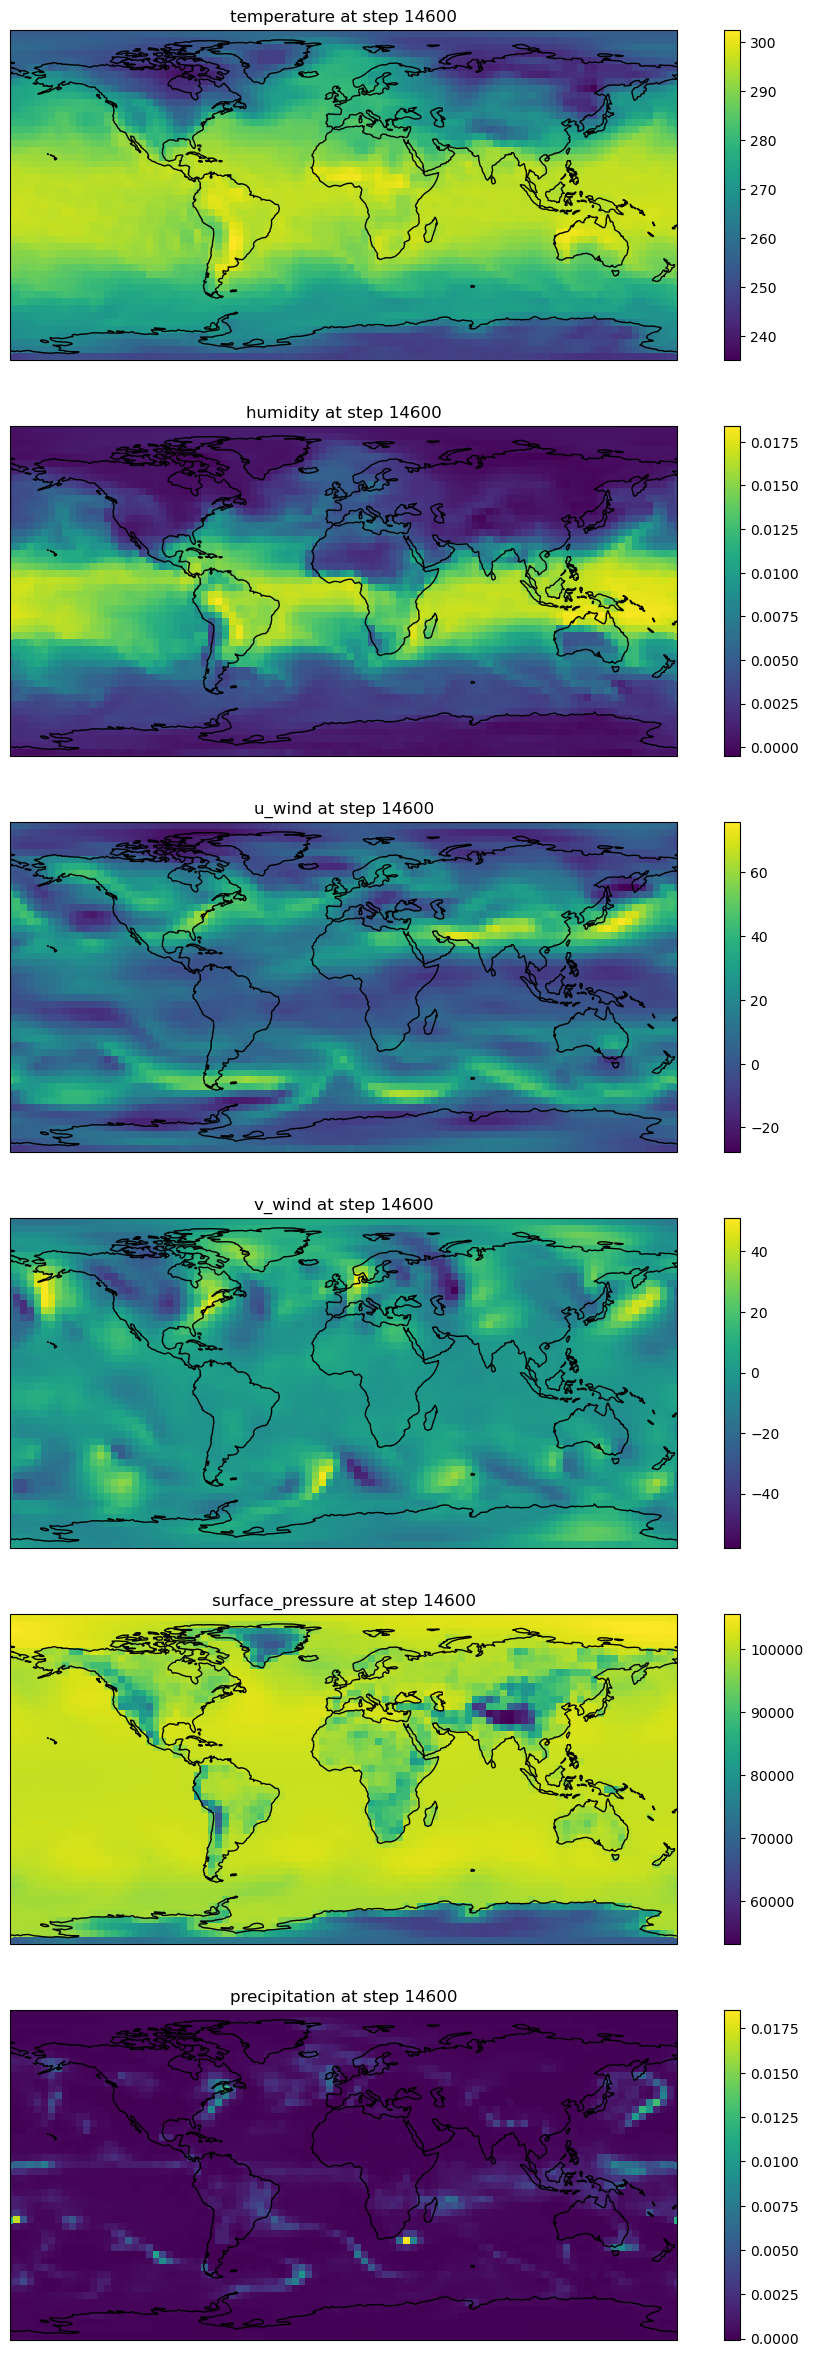

In [ ]:
#results from Yue's checkpoint
# path = torch.load(f'{wdir}/checkpoints/136618981.gadi-pbs/regular_training_checkpoint.pth')
# model.load_state_dict(path)

# better checkpoint
#path = torch.load(f'{wdir}/checkpoints/137286020.gadi-pbs/lucie_205.pt')
#path = torch.load(f'{wdir}/checkpoints/137478626.gadi-pbs/lucie_158.pt')
#path = torch.load(f'{wdir}/checkpoints/138987659.gadi-pbs/lucie_340.pt')

#model.load_state_dict(path["model_state_dict"])

#rollout = inference(model, rollout_step, data_inp[initial_frame_idx].unsqueeze(0).to(device), forcing.to(device), forcing_initial_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds)


# visualize the final timestep of each ouptut var
w,h = 12,5
fig,axs = plt.subplots(nvars,1, figsize=(w,h*nvars),subplot_kw={'projection': ccrs.PlateCarree()},squeeze=False)
Lon, Lat = np.meshgrid(lon, lat)
for ii in range(nvars):
    pcm = axs[ii,0].pcolormesh(Lon,Lat,rollout[-1,ii,:,:])
    axs[ii,0].coastlines()
    axs[ii,0].set_title(f"{vars[ii]} at step {rollout.shape[0]}")
    fig.colorbar(pcm, ax=axs[ii])

## Check Climatology Bias 

In [ ]:
# mean clim_bias between year 1 and 10, it is expected to be different from what reported in the training 
rollout_clim = torch.mean(torch.tensor(rollout[1460:]).to(device),dim=0)
clim_bias = torch.mean(torch.abs(rollout_clim - true_clim))
clim_bias

tensor(18.2533, device='cuda:0')

In [ ]:
# relative clim_bias by vars
rel_clim_bias = torch.mean(torch.abs((rollout_clim - true_clim)/true_clim),dim=(-2,-1))
list(zip(vars,rel_clim_bias.tolist()))

[('temperature', 0.0021463886369019747),
 ('humidity', 0.09310100972652435),
 ('u_wind', 2.2337892055511475),
 ('v_wind', 2.5637850761413574),
 ('surface_pressure', 0.001107409130781889),
 ('precipitation', 0.14571672677993774)]

## Compare Global Mean over Time

In [ ]:
# Compare global mean over time [year 1, year 10]
data = load_data(f"{nb_dir}/datasets/era5_T30_regridded.npz")[...,:6]
true_clim_t = np.mean(data[1460:14600], axis=(1,2))
pred = torch.tensor(rollout[1460:]).detach()
pred_clim_t = torch.mean(pred,dim=(-1,-2))

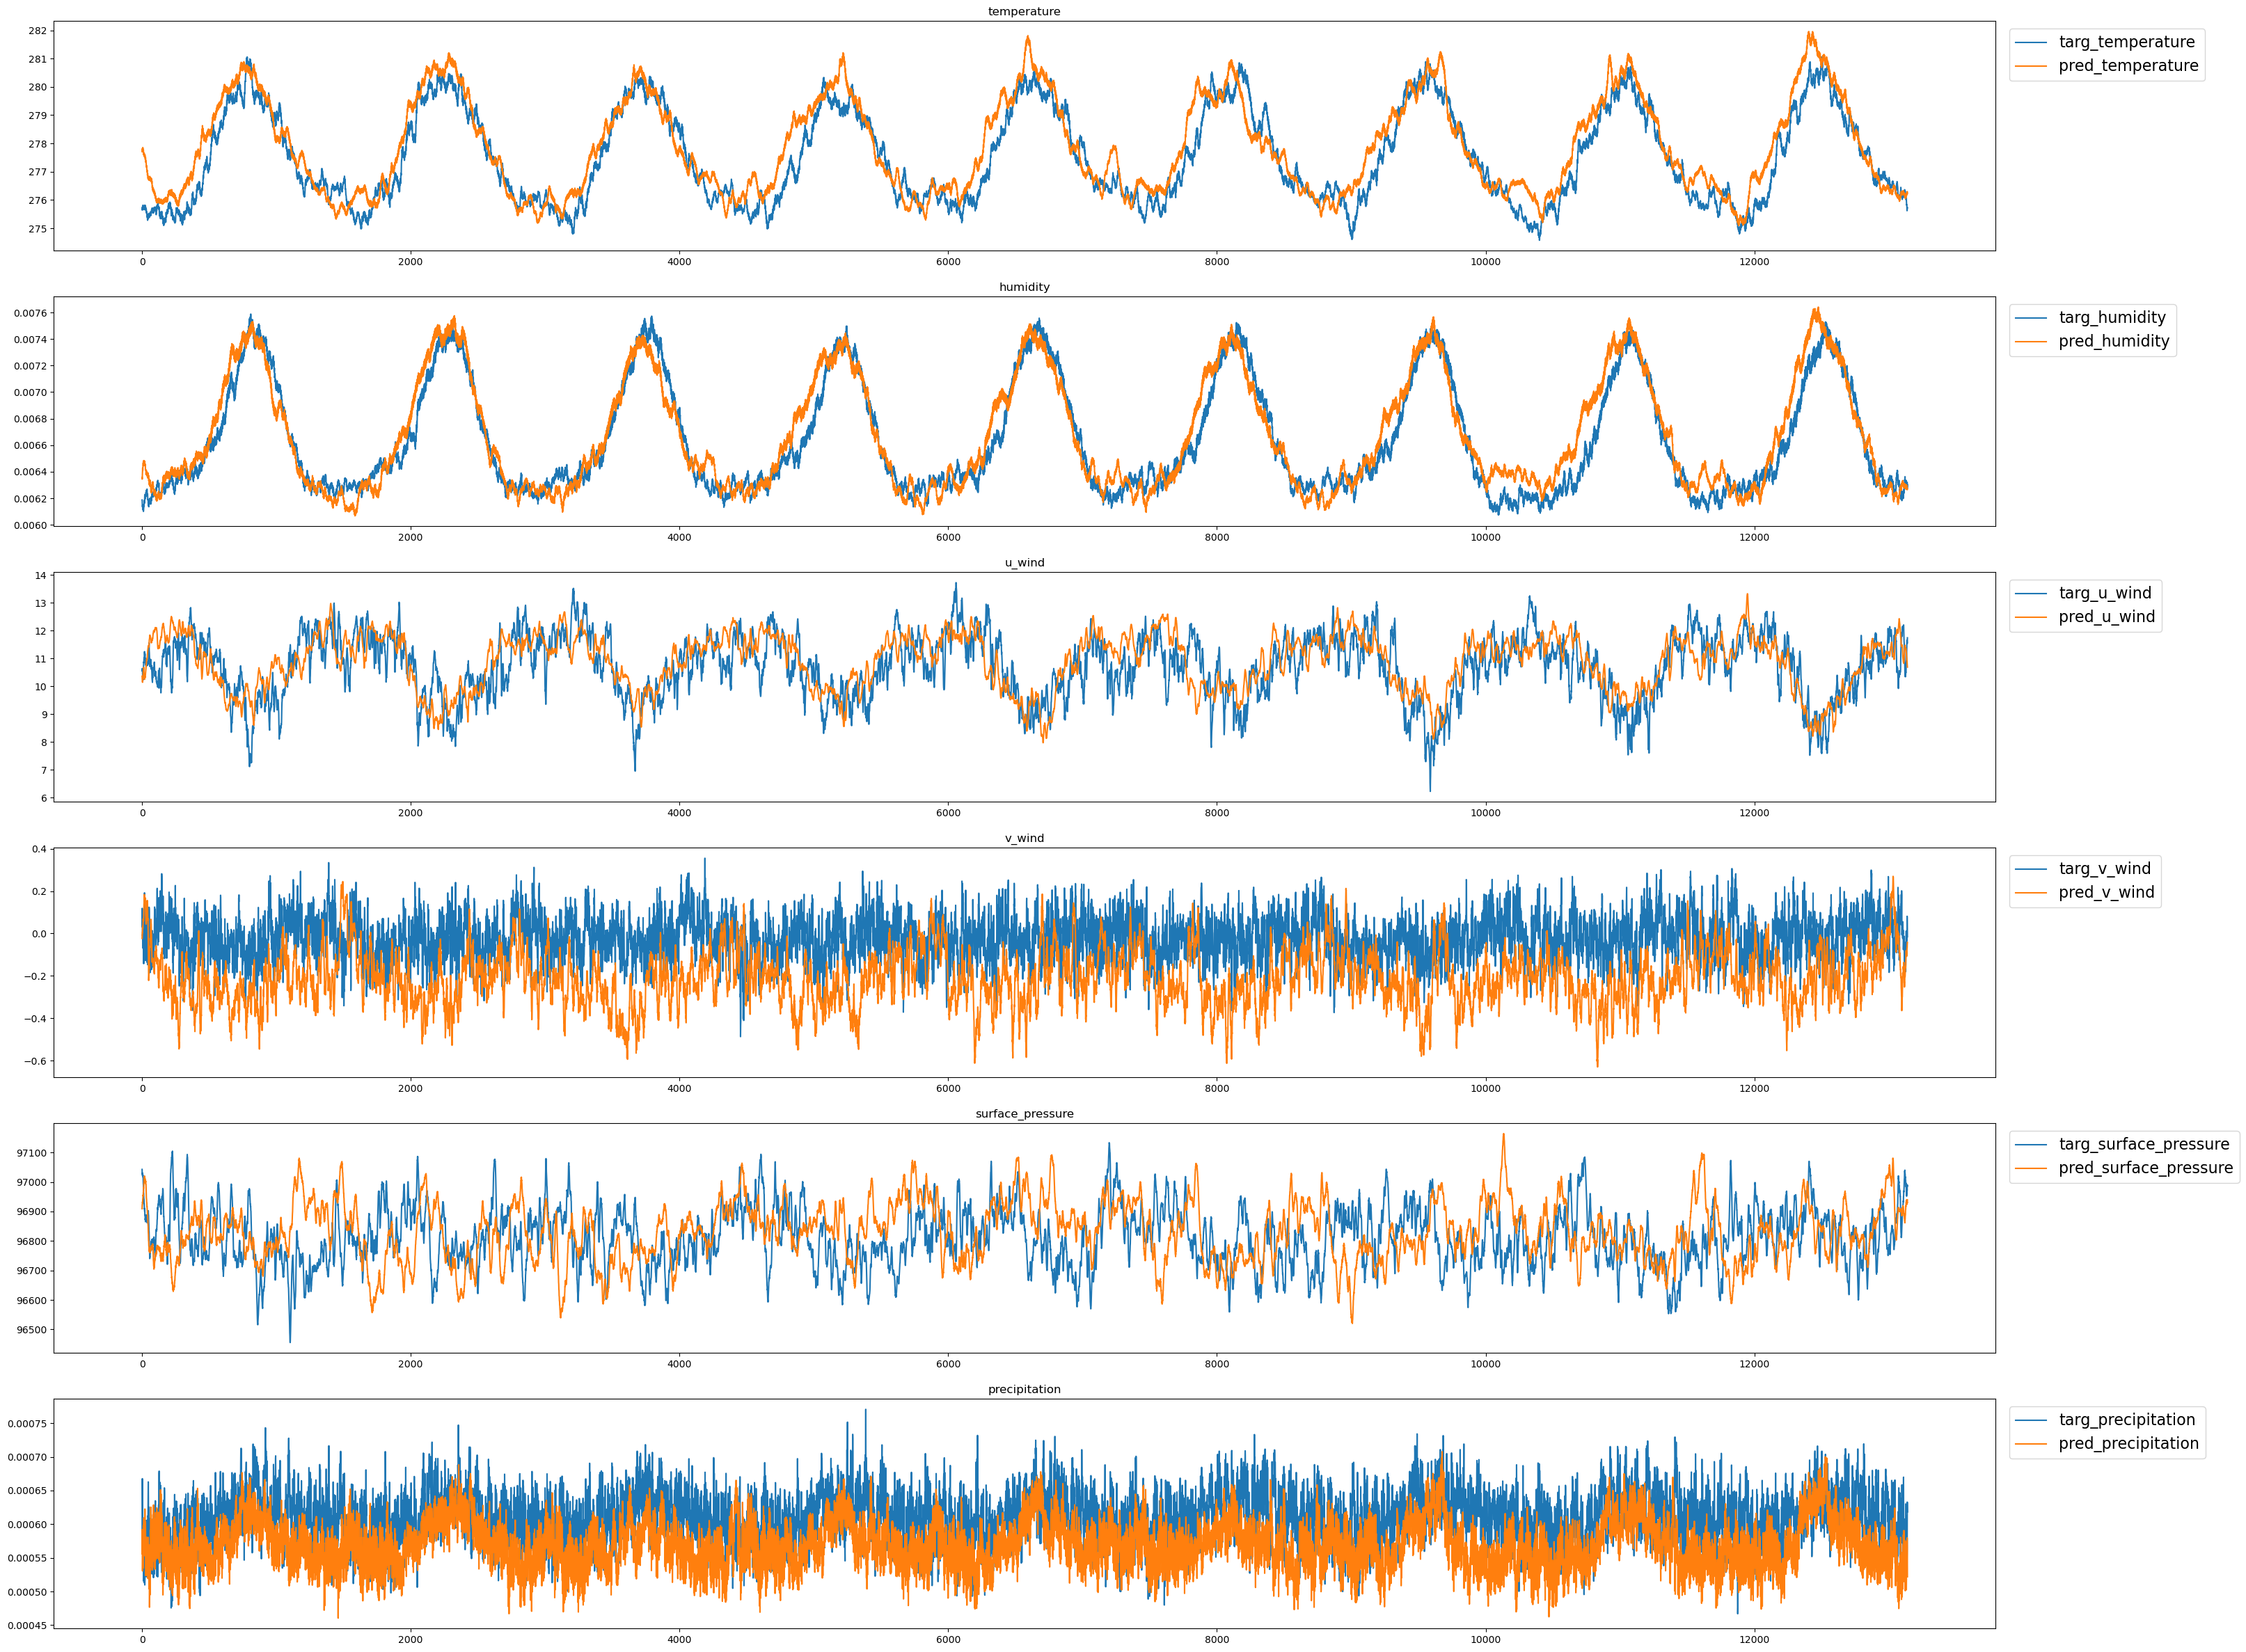

In [ ]:
fig,axs = plt.subplots(nvars,1, figsize=(w*3,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

## Suggested Exercises
1. Compare rollout results from both checkpoints.  
2. Use a different metric to quantify the difference between prediction and the ground truth over time.  
3. Track the spatial pattern evolution of an individual variable field over time.  
4. Run the notebook `/g/data/dk92/notebooks/examples-aiml/lucie/modified_training.ipynb` and generate the 10-year inference for its model with the checkpoints `nci_mod_lucie_193.pt` and/or `nci_mod_lucie_219.pt` inside the directory `/g/data/dk92/notebooks/examples-aiml/lucie/checkpoints/`.  